In [30]:
import requests
from bs4 import BeautifulSoup 
from lxml import etree

import re
from pathlib import Path
import os


import cv2
import numpy as np

# helper function
import my_helper as helper



# Haar Cascade

1. In real world no two object are exact similar under the microscope.
2. But we can say that two object are similar based on some similarities.
3. These similarities are called Feature.We need extract these features.
4. Haar feature describe **the intensity difference between the adjacent region.**
5. It contain the pattern like edge ,line,vertices.
6. Some feature are distinctive that only in the subset of object not in all object.
7. These distinctive feature are arrange in cascade, top one contain the highest distinctive power.
8. Haar cascade are scale invariant. 

In [2]:
res = requests.get("https://github.com/opencv/opencv/tree/master/data/haarcascades")
BASE_URL = "https://github.com"

In [3]:
soup = BeautifulSoup(res.content,"html.parser")
dom = etree.HTML(str(soup))

In [4]:
BASE_PATH = Path("../data/haarcascades/")
BASE_PATH.mkdir(parents=True,exist_ok=True)

In [5]:
elements = dom.xpath('//*[@id="repo-content-pjax-container"]/div/div/div[4]/div[3]/div/*/*[@role="rowheader"]//*[@href]')
for ele in elements[1:]:
    blob_url  = ele.attrib["href"]    
    filename = ele.text
    raw_url = BASE_URL +  re.sub("blob","raw",blob_url)
    file_path = BASE_PATH/filename
    if file_path.is_file():
        continue
    file_res = requests.get(raw_url,stream=True)
    if file_res.status_code == 200:
        with open(str(BASE_PATH)+"/"+filename,"wb") as f:
            for chunk in file_res.iter_content(chunk_size=1024):
                f.write(chunk)      

In [6]:
def download_folder_github(url,save_path):
    base_url = "https://github.com"
    base_path = Path(save_path)
    base_path.mkdir(parents=True,exist_ok=True)
    res = requests.get(url)
    soup = BeautifulSoup(res.content,"html.parser")
    dom = etree.HTML(str(soup))
    elements = dom.xpath('//*[@id="repo-content-pjax-container"]/div/div/div[4]/div[3]/div/*/*[@role="rowheader"]//*[@href]')
    for ele in elements[1:]:
        blob_url = ele.attrib["href"]
        filename = ele.text
        raw_url = base_url + re.sub("blob","raw",blob_url)
        file_path = base_path/filename
        if file_path.is_file():
            print(f'File already exists skipping download file {filename}')
            continue
        file_res = requests.get(raw_url,stream=True)
        if file_res.status_code == 200:
            print(f'Downloading file {filename}')
            with open(file_path,"wb") as f:
                for chunk in file_res.iter_content(chunk_size=1024):
                    f.write(chunk)
        else:
            print(f'Error getting the content from url {raw_url}')

In [7]:
download_folder_github("https://github.com/opencv/opencv/tree/master/data/haarcascades","../data/haarcascades/")

File already exists skipping download file haarcascade_eye.xml
File already exists skipping download file haarcascade_eye_tree_eyeglasses.xml
File already exists skipping download file haarcascade_frontalcatface.xml
File already exists skipping download file haarcascade_frontalcatface_extended.xml
File already exists skipping download file haarcascade_frontalface_alt.xml
File already exists skipping download file haarcascade_frontalface_alt2.xml
File already exists skipping download file haarcascade_frontalface_alt_tree.xml
File already exists skipping download file haarcascade_frontalface_default.xml
File already exists skipping download file haarcascade_fullbody.xml
File already exists skipping download file haarcascade_lefteye_2splits.xml
File already exists skipping download file haarcascade_license_plate_rus_16stages.xml
File already exists skipping download file haarcascade_lowerbody.xml
File already exists skipping download file haarcascade_profileface.xml
File already exists sk

In [8]:
helper.download_image("https://raw.githubusercontent.com/PacktPublishing/Learning-OpenCV-4-Computer-Vision-with-Python-Third-Edition/master/images/woodcutters.jpg","wood")

[INFO] downloading image and saving to ../images/wood.jpg


# Performing face detection on a still image

In [9]:
face_cascade = cv2.CascadeClassifier("../data/haarcascades/haarcascade_frontalface_default.xml")

# read the image
img = cv2.imread("../images/wood.jpg")
# convert the gray scale
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

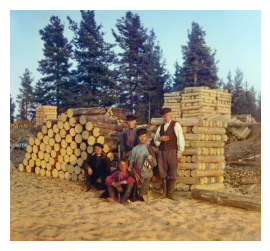

In [10]:
helper.plot_img(img)

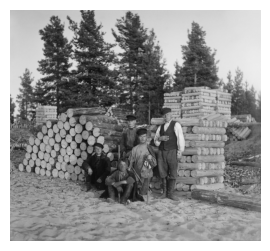

In [11]:
helper.plot_img(gray_img)

In [12]:
help(face_cascade.detectMultiScale)

Help on built-in function detectMultiScale:

detectMultiScale(...) method of cv2.CascadeClassifier instance
    detectMultiScale(image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]]]]]) -> objects
    .   @brief Detects objects of different sizes in the input image. The detected objects are returned as a list
    .       of rectangles.
    .   
    .       @param image Matrix of the type CV_8U containing an image where objects are detected.
    .       @param objects Vector of rectangles where each rectangle contains the detected object, the
    .       rectangles may be partially outside the original image.
    .       @param scaleFactor Parameter specifying how much the image size is reduced at each image scale.
    .       @param minNeighbors Parameter specifying how many neighbors each candidate rectangle should have
    .       to retain it.
    .       @param flags Parameter with the same meaning for an old cascade as in the function
    .       cvHaarDetectObjects. I

In [13]:
# detect the multiple scale face, as we said that HAAR Cascade is scale invariant,
# this achieved by the down-sampling the image in different scale think as the image pyramid
#? so we pass the scale factor as a argument to the detectMultiScale 
#! scale factor should the grater than 1 so that each iteration the image get downsampled
faces = face_cascade.detectMultiScale(image=gray_img,
                              scaleFactor= 1.08,
                              minNeighbors=5)
#? the minimum number of overlapping detections that are required in order to retain a 
#? detection result.
#! return the face rectangle
faces

array([[442, 425,  33,  33],
       [375, 525,  31,  31],
       [291, 470,  27,  27]])

In [14]:
for (x,y,w,h) in faces:
    img = cv2.rectangle(img=img,
                        pt1=(x,y),
                        pt2=(x+w,y+h),
                        color=(0,255,0),
                        thickness=2)

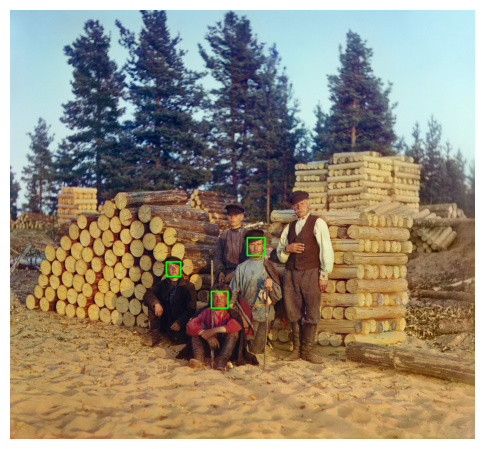

In [15]:
helper.plot_img(img,figsize=(6,6))

# Performing the face detection in video

In [16]:
face_cascade = cv2.CascadeClassifier("../data/haarcascades/haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("../data/haarcascades/haarcascade_eye.xml")

In [20]:
camera = cv2.VideoCapture(0)
while cv2.waitKey(1) == -1:
    success,frame = camera.read()
    if success:
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray,1.3,5,minSize = (150,150))
        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),color=(0,255,0),
                          thickness=3)
            roi_gray = gray[y:y+h,x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray,1.3,5,minSize=(40,40))
            for (ex,ey,ew,eh) in eyes:
                cv2.rectangle(frame,(x+ex,y+ey),
                              (x+ex+ew,y+ey+eh),(0,255,0),2)
        cv2.imshow("Face Detection",frame)
camera.release()
cv2.destroyAllWindows()

# Face Recognition

## Generate data

In [39]:
face_path = Path("../data/face/ak")
face_path.mkdir(parents=True,exist_ok=True)

In [40]:
face_cascade = cv2.CascadeClassifier("../data/haarcascades/haarcascade_frontalface_default.xml")

In [41]:
help(face_cascade.detectMultiScale)

Help on built-in function detectMultiScale:

detectMultiScale(...) method of cv2.CascadeClassifier instance
    detectMultiScale(image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]]]]]) -> objects
    .   @brief Detects objects of different sizes in the input image. The detected objects are returned as a list
    .       of rectangles.
    .   
    .       @param image Matrix of the type CV_8U containing an image where objects are detected.
    .       @param objects Vector of rectangles where each rectangle contains the detected object, the
    .       rectangles may be partially outside the original image.
    .       @param scaleFactor Parameter specifying how much the image size is reduced at each image scale.
    .       @param minNeighbors Parameter specifying how many neighbors each candidate rectangle should have
    .       to retain it.
    .       @param flags Parameter with the same meaning for an old cascade as in the function
    .       cvHaarDetectObjects. I

In [42]:
camera = cv2.VideoCapture(0)
count = 0 
while cv2.waitKey(1) == -1:
    success,frame = camera.read()
    if success:
        # gray image
        gray_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame,scaleFactor=1.3,
                                              minNeighbors=5,minSize=(200,200))
        for x,y,w,h in faces:
            cv2.rectangle(img=frame,
                          pt1=(x,y),
                          pt2=(x+w,y+h),
                          color=(0,255,0),
                          thickness=2)
            face_img = cv2.resize(gray_frame[y:y+h,x:x+h],
                                  dsize=(200,200))
            face_filename = face_path / f"{count}.pgm"
            cv2.imwrite(filename=str(face_filename),
                        img=face_img)
            count += 1
        cv2.imshow("Capturing Faces",frame)
camera.release()
cv2.destroyAllWindows()

## Loading data for face Recognition

In [47]:
def read_images(path,image_size):
    names = []
    training_images,training_labels = [], []
    label = 0
    for dirname,sub_dirs,filenames in os.walk(path):
        for sub_dir in sub_dirs:
            names.append(sub_dir)
            face_path = os.path.join(dirname,sub_dir)
            for filename in os.listdir(face_path):
                img = cv2.imread(os.path.join(face_path,filename),
                                 cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img,image_size)
                training_images.append(img)
                training_labels.append(label)
            label += 1
    training_images = np.asarray(training_images,dtype=np.uint8)
    training_labels = np.asarray(training_labels,dtype=np.int32)
    return names,training_images,training_labels

In [48]:
path_to_training_images = "../data/face/"
names,training_images,training_labels = read_images(path_to_training_images,(200,200))

In [49]:
training_images.shape

(284, 200, 200)

## Performing face recognition with EigenValues

In [51]:
model = cv2.face.EigenFaceRecognizer_create()
model.train(training_images,training_labels)

In [52]:
face_cascade = cv2.CascadeClassifier("../data/haarcascades/haarcascade_frontalface_default.xml")

In [53]:
help(face_cascade.detectMultiScale)

Help on built-in function detectMultiScale:

detectMultiScale(...) method of cv2.CascadeClassifier instance
    detectMultiScale(image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]]]]]) -> objects
    .   @brief Detects objects of different sizes in the input image. The detected objects are returned as a list
    .       of rectangles.
    .   
    .       @param image Matrix of the type CV_8U containing an image where objects are detected.
    .       @param objects Vector of rectangles where each rectangle contains the detected object, the
    .       rectangles may be partially outside the original image.
    .       @param scaleFactor Parameter specifying how much the image size is reduced at each image scale.
    .       @param minNeighbors Parameter specifying how many neighbors each candidate rectangle should have
    .       to retain it.
    .       @param flags Parameter with the same meaning for an old cascade as in the function
    .       cvHaarDetectObjects. I

In [54]:
camera = cv2.VideoCapture(0)
while cv2.waitKey(1) == -1 :
    success , frame = camera.read()
    if success:
        faces = face_cascade.detectMultiScale(frame,scaleFactor=1.3,minNeighbors=5,
                                              minSize=(200,200))
        for x,y,w,h in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            roi_gray = gray[y:y+h,x:x+w]
            if roi_gray.size == 0:
                continue
            roi_gray = cv2.resize(roi_gray,(200,200))
            label,confidence = model.predict(roi_gray)
            text = f"{names[label]} ,conf = {confidence:.2%}"
            cv2.putText(frame,text,(x,y-20),
                        cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
        cv2.imshow("Face Recognition",frame)
camera.release()
cv2.destroyAllWindows()

## Performing face recognition with Fisherfaces

In [56]:
model = cv2.face.FisherFaceRecognizer_create()
model.train(training_images,training_labels)

In [57]:
camera = cv2.VideoCapture(0)
while cv2.waitKey(1) == -1 :
    success , frame = camera.read()
    if success:
        faces = face_cascade.detectMultiScale(frame,scaleFactor=1.3,minNeighbors=5,
                                              minSize=(200,200))
        for x,y,w,h in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            roi_gray = gray[y:y+h,x:x+w]
            if roi_gray.size == 0:
                continue
            roi_gray = cv2.resize(roi_gray,(200,200))
            label,confidence = model.predict(roi_gray)
            text = f"{names[label]} ,conf = {confidence:.2%}"
            cv2.putText(frame,text,(x,y-20),
                        cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
        cv2.imshow("Face Recognition",frame)
camera.release()
cv2.destroyAllWindows()


## Performing face recognition with LBPH

In [58]:
model = cv2.face.LBPHFaceRecognizer_create()
model.train(training_images,training_labels)

In [59]:
camera = cv2.VideoCapture(0)
while cv2.waitKey(1) == -1 :
    success , frame = camera.read()
    if success:
        faces = face_cascade.detectMultiScale(frame,scaleFactor=1.3,minNeighbors=5,
                                              minSize=(200,200))
        for x,y,w,h in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            roi_gray = gray[y:y+h,x:x+w]
            if roi_gray.size == 0:
                continue
            roi_gray = cv2.resize(roi_gray,(200,200))
            label,confidence = model.predict(roi_gray)
            text = f"{names[label]} ,conf = {confidence:.2%}"
            cv2.putText(frame,text,(x,y-20),
                        cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
        cv2.imshow("Face Recognition",frame)
camera.release()
cv2.destroyAllWindows()
